In [1]:
import math
import numpy as np
from disturbances import IntegratedWhiteNoise
import os
from constants import *
from diff_calc import get_mass_matrix
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Reading from a MCAP file
from mcap_ros2.reader import read_ros2_messages

pos = np.empty((3, 0))
vel = np.empty((3, 0))
acc = np.empty((3, 0))

for msg in read_ros2_messages("../bagfiles/record8/record8_0.mcap"):
    if msg.channel.topic == "/model/vereniki/odometry":
        # print(f"{msg.ros_msg.pose.pose.position.x}: \n")
        pos = np.column_stack((pos, np.array([msg.ros_msg.pose.pose.position.x,
                                              msg.ros_msg.pose.pose.position.y,
                                              msg.ros_msg.pose.pose.orientation.z])))
        vel = np.column_stack((vel, np.array([msg.ros_msg.twist.twist.linear.x,
                                              msg.ros_msg.twist.twist.linear.y,
                                              msg.ros_msg.twist.twist.angular.z])))
    if msg.channel.topic == "/model/vereniki/imu":
        # print(f"{msg.ros_msg.linear_acceleration.x}")
        acc = np.column_stack((acc, np.array([msg.ros_msg.linear_acceleration.x,
                                              msg.ros_msg.linear_acceleration.y,
                                              0])))

    
odom_data = {'Position-x': pos[0, :], 
        'Position-y': pos[1, :], 
        'Orientation-z': pos[2, :],
        'Velocity-x': vel[0, :],
        'Velocity-y': vel[1, :],
        'Velocity-z': vel[2, :]}

imu_data= {'Acceleration-x': acc[0, :],
           'Acceleration-y': acc[1, :],
           'Acceleration-z': acc[2, :]}
odom_sim_data = pd.DataFrame(odom_data)
imu_sim_data = pd.DataFrame(imu_data)
odom_data_size = odom_sim_data.shape[0]
imu_data_size = imu_sim_data.shape[0]

In [4]:
def align_values(data, size):
    selected_indices = np.linspace(0, len(data) - 1, size, dtype=int)
    return data.iloc[selected_indices].reset_index(drop=True)

In [5]:
diff_data = pd.read_csv('output.csv')
diff_data

,Position-x,Position-y,Orientation-z,Velocity-x,Velocity-y,Velocity-z,Acceleration-x,Acceleration-y,Acceleration-z
0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,0.000000e+00,0.000000,0.001307,0.000000e+00,0.000041,1.307190e-01,0.000000e+00,4.078554e-03
2,0.000013,0.000000e+00,0.000023,0.002033,-6.055090e-13,0.000048,7.262088e-02,-6.055090e-11,7.635888e-04
3,0.000033,8.287270e-12,0.000051,0.003018,-9.886644e-13,0.000083,9.844117e-02,-3.831554e-11,3.457828e-03
4,0.000064,3.519835e-11,0.000099,0.003887,-3.030430e-12,0.000096,8.696327e-02,-2.041766e-10,1.267878e-03
...,...,...,...,...,...,...,...,...,...
5995,29.373202,6.494289e+00,23.563007,0.542712,-2.902402e-06,0.006870,8.366451e-10,1.916038e-10,-2.032660e-10
5996,29.378177,6.496459e+00,23.566943,0.542712,-2.902400e-06,0.006870,8.338933e-10,1.912848e-10,-2.026357e-10
5997,29.383151,6.498629e+00,23.570879,0.542712,-2.902398e-06,0.006870,8.311506e-10,1.909664e-10,-2.020073e-10
5998,29.388126,6.500799e+00,23.574816,0.542712,-2.902396e-06,0.006870,8.284169e-10,1.906485e-10,-2.013809e-10


In [9]:
pd.DataFrame(imu_data)

,Acceleration-x,Acceleration-y,Acceleration-z
0,0.163742,-0.379800,0.0
1,0.163742,-0.379800,0.0
2,-0.014587,0.335644,0.0
3,-0.014587,0.335644,0.0
4,0.125777,-0.226640,0.0
...,...,...,...
121569,-0.032618,0.005059,0.0
121570,-0.032618,0.005059,0.0
121571,-0.032618,0.005059,0.0
121572,-0.032618,0.005059,0.0


In [12]:
x_pos_diff = align_values(diff_data['Position-x'], odom_data_size)
y_pos_diff = align_values(diff_data['Position-y'], odom_data_size)
z_orient_diff = align_values(diff_data['Orientation-z'], odom_data_size)

x_vel_diff = align_values(diff_data['Velocity-x'], odom_data_size)
y_vel_diff = align_values(diff_data['Velocity-y'], odom_data_size)
z_vel_diff = align_values(diff_data['Velocity-z'], odom_data_size)

x_acc_diff = align_values(diff_data['Acceleration-x'], imu_data_size)
y_acc_diff = align_values(diff_data['Acceleration-y'], imu_data_size)
z_acc_diff = align_values(diff_data['Acceleration-z'], imu_data_size)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


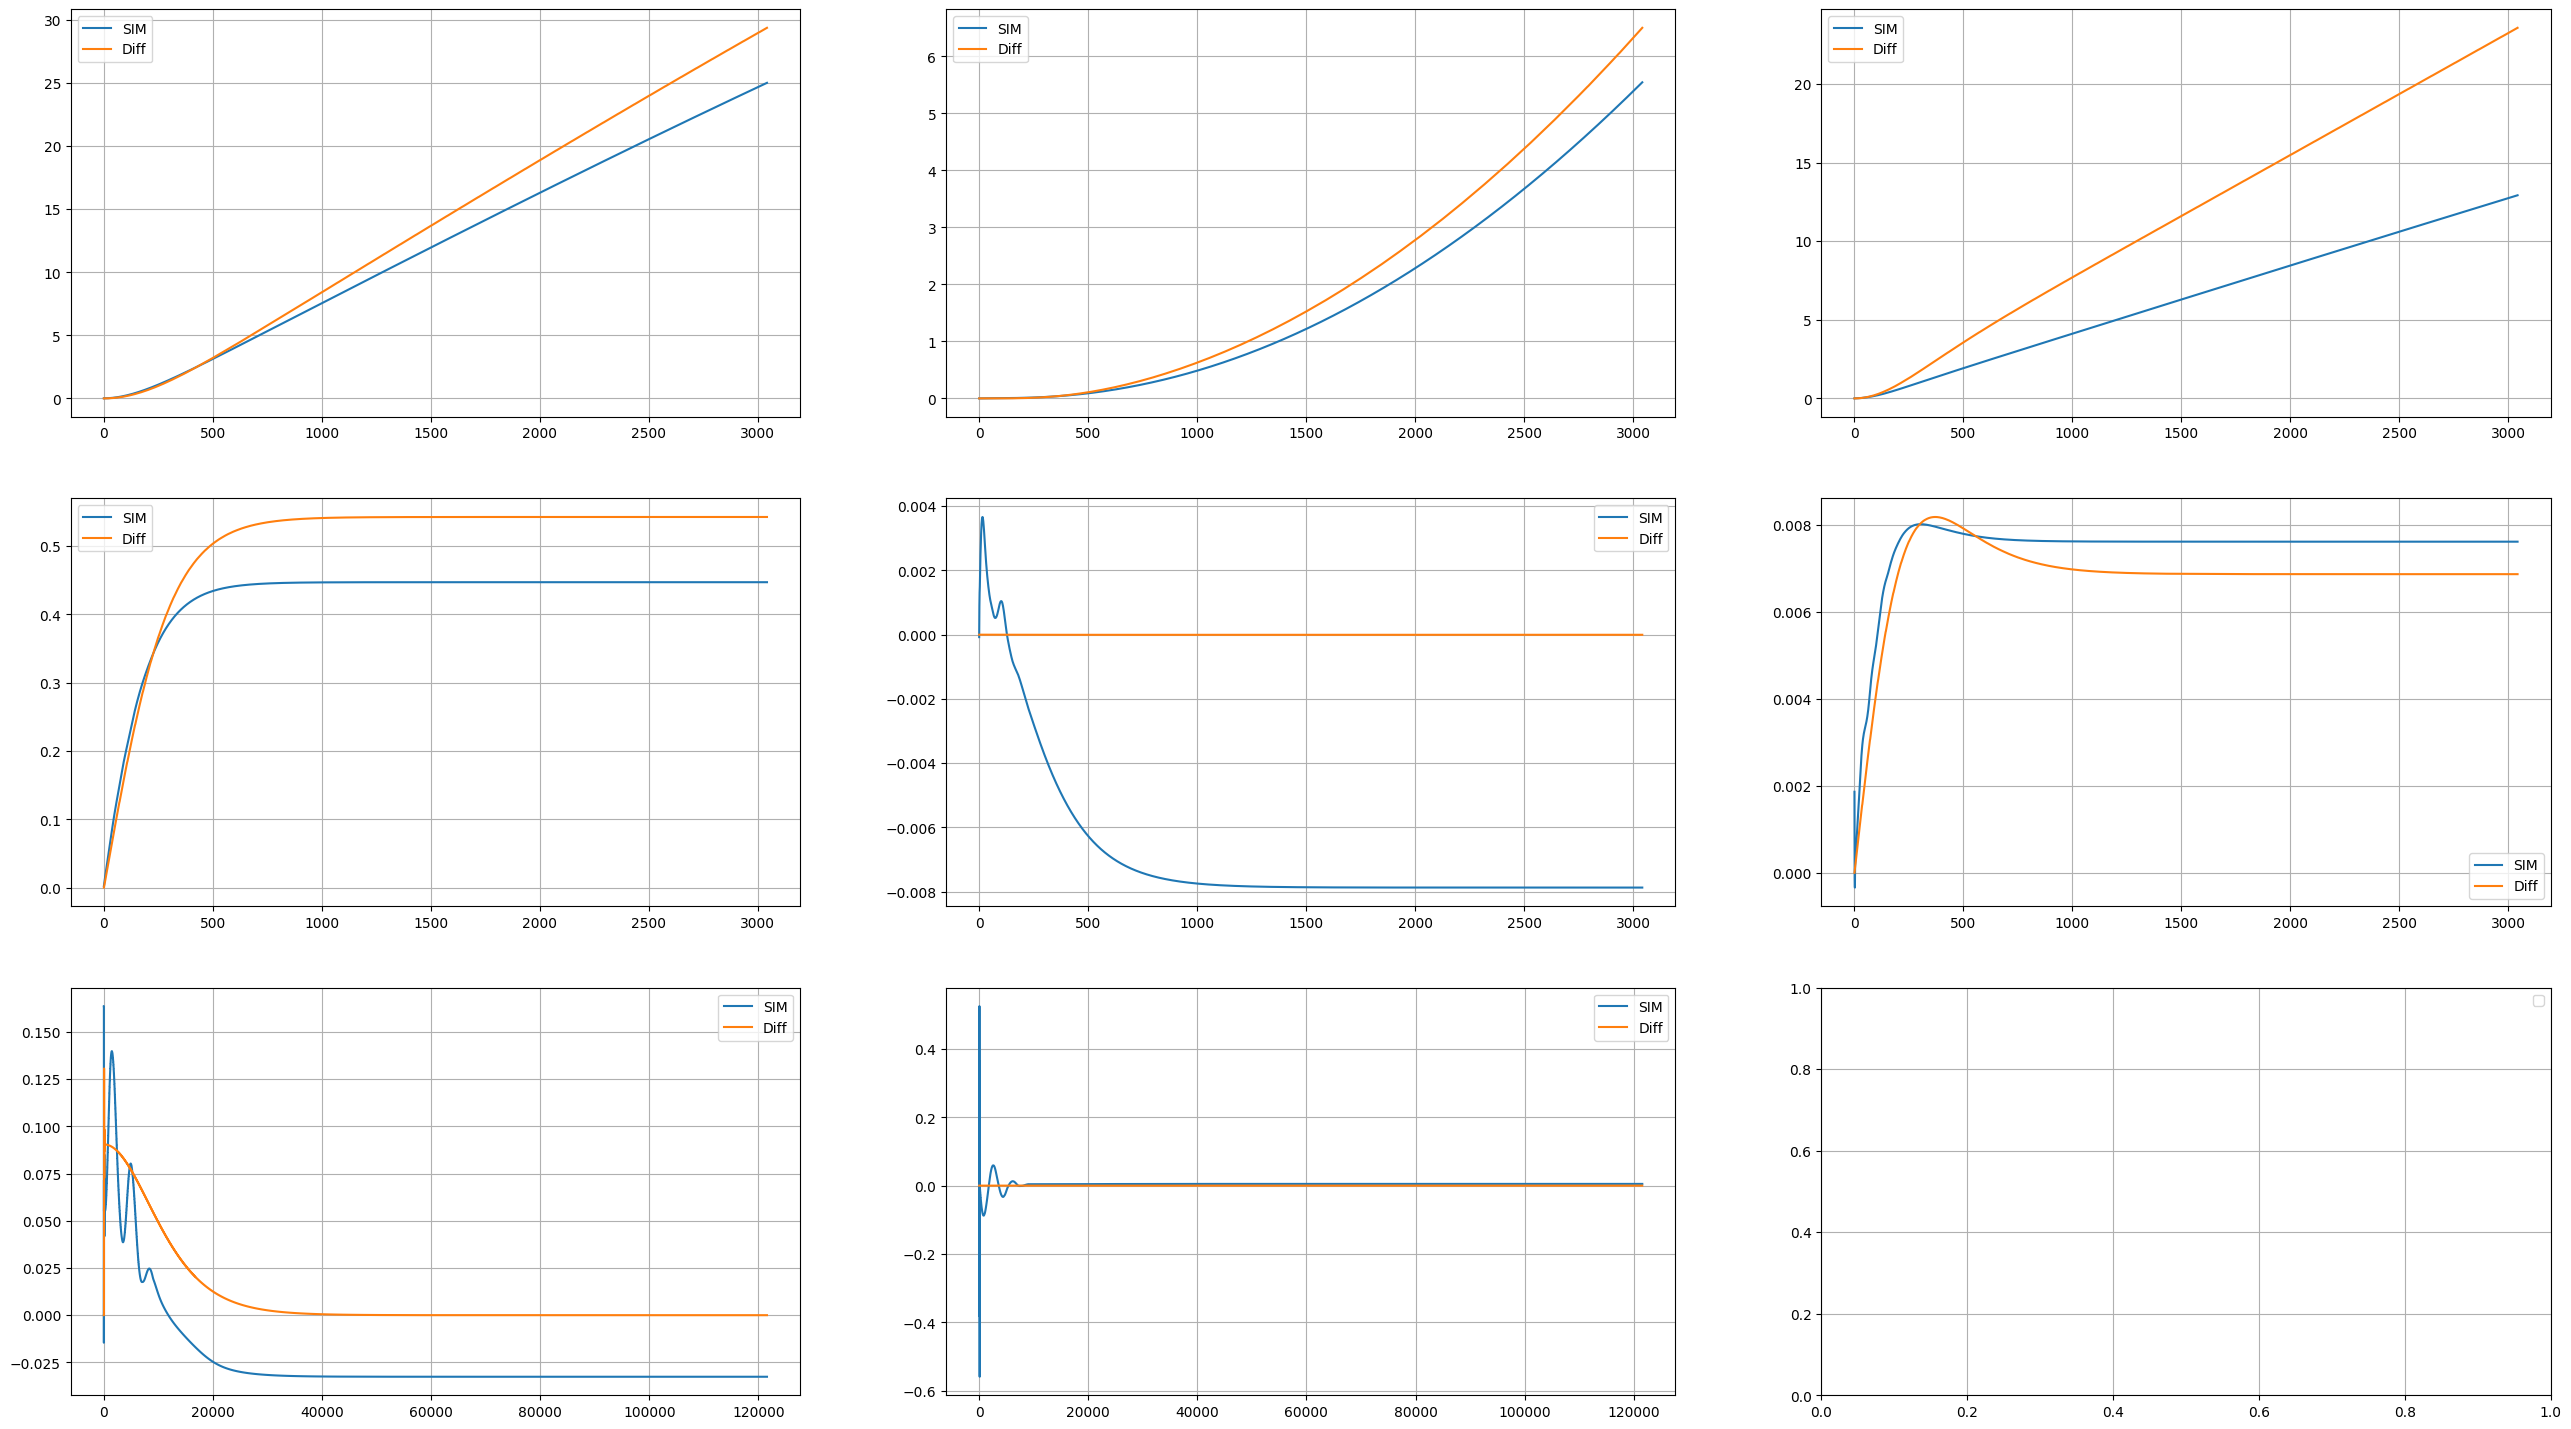

In [20]:
def radians_to_degrees(radians):
    degrees = np.degrees(radians)
    degrees = (degrees + 180) % 360 - 180
    return degrees

fig, ax = plt.subplots(3, 3, sharex=False, sharey=False)
fig.set_figwidth(32)
fig.set_figheight(18)

# Pose 

ax[0, 0].plot(odom_data['Position-x'], label='SIM')
ax[0, 0].plot(x_pos_diff, label='Diff')

ax[0, 1].plot(odom_data['Position-y'], label='SIM')
ax[0, 1].plot(y_pos_diff, label='Diff')

ax[0, 2].plot(pd.DataFrame(odom_data['Orientation-z']).apply(radians_to_degrees), label='SIM')
ax[0, 2].plot(z_orient_diff, label='Diff')

# Twist
ax[1, 0].plot(odom_data['Velocity-x'], label='SIM')
ax[1, 0].plot(x_vel_diff, label='Diff')

ax[1, 1].plot(odom_data['Velocity-y'], label='SIM')
ax[1, 1].plot(y_vel_diff, label='Diff')

ax[1, 2].plot(pd.DataFrame(odom_data['Velocity-z']), label='SIM')
ax[1, 2].plot(z_vel_diff, label='Diff')

# Acceleration
ax[2, 0].plot(imu_data['Acceleration-x'], label='SIM')
ax[2, 0].plot(x_acc_diff, label='Diff')

ax[2, 1].plot(imu_data['Acceleration-y'], label='SIM')
ax[2, 1].plot(y_acc_diff, label='Diff')

# ax[2, 2].plot(pd.DataFrame(odom_data['Velocity-z']), label='SIM')
# ax[2, 2].plot(z_vel_diff, label='Diff')

for i in range(3):
    for j in range(3):
        ax[i, j].grid(True)
        ax[i, j].legend()

plt.show()

In [39]:
z_orient_diff

0        0.000000
1        0.000000
2        0.000051
3        0.000153
4        0.000307
          ...    
3038    23.547261
3039    23.555134
3040    23.563007
3041    23.570879
3042     0.411527
Name: Orientation-z, Length: 3043, dtype: float64